In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import os

import numpy as np
import bloscpack as bp
%matplotlib inline

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *

from registration_utilities import *
from annotation_utilities import *
from vis3d_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for Local Macbook Pro


In [2]:
def cartesian_to_polar_3d(v):
    """x,y,z to theta,phi,r
    reference: http://keisan.casio.com/exec/system/1359533867
    """
    r = np.sqrt(v[:,0]**2+v[:,1]**2+v[:,2]**2)
#     theta = np.arctan(v[:,1]/v[:,0])
    theta = np.arctan2(v[:,1], v[:,0])
#     phi = np.arctan(np.sqrt(v[:,0]**2+v[:,1]**2)/v[:,2])
    phi = np.arctan2(np.sqrt(v[:,0]**2+v[:,1]**2), v[:,2])
    return np.column_stack([theta,phi,r])

def polat_to_cartesian_3d(p):
    """
    theta,phi,r to x,y,z
    http://keisan.casio.com/exec/system/1359534351
    """
    theta = p[:,0]
    phi = p[:,1]
    r = p[:,2]
    x = r*np.sin(phi)*np.cos(theta)
    y = r*np.sin(phi)*np.sin(theta)
    z = r*np.cos(phi)
    return np.column_stack([x,y,z])

In [3]:
from scipy.special import sph_harm

In [110]:
# Reference: 
# http://www.cs.dartmouth.edu/farid/downloads/publications/evolution08a.pdf
# http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0134603&type=printable

L = 5 # max degree of spherical harmonics
ml_list = [(m,l) for l in range(0, L+1) for m in range(-l, l+1)]
spharm_allInstances = np.zeros((6, 3, len(ml_list)))

for instance_idx in range(6):
    
    fp = DataManager.get_instance_mesh_filepath(atlas_name='atlasV5', structure='7n', index=instance_idx)
    vertices, faces = load_mesh_stl(fp, return_polydata_only=False)

    # Map to unit-sphere

    c = vertices.mean(axis=0)
    vertices = vertices - c

    # xyz_max = np.abs(vertices).max(axis=0)
    # vertices_normalized = vertices/xyz_max
    rmax = np.sqrt(vertices[:,0]**2+vertices[:,1]**2+vertices[:,2]**2).max()
    vertices_normalized = vertices/rmax
    # Resizing to same surface area does not make much difference.
    resize_to_same_surface_area_factor = np.sqrt(4*np.pi / mesh_surface_area(vertices_normalized, faces))
    vertices_normalized = vertices_normalized * resize_to_same_surface_area_factor

    polars = cartesian_to_polar_3d(vertices_normalized)

    # Spherical harmonics
    # https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.special.sph_harm.html
    Ax = np.array([[np.real(sph_harm(m,l,theta,phi)) if m >= 0 else np.imag(sph_harm(m,l,theta,phi)) 
                    for m, l in ml_list] for theta,phi,r in polars])

    spharm_coeffs = np.zeros((3,len(ml_list)))
    for i in range(3):
        spharm_coeffs[i], residual, _, _ = np.linalg.lstsq(Ax, vertices_normalized[:,i])
#         print 'xyz'[i], 'residual', residual

    spharm_allInstances[instance_idx] = spharm_coeffs

# Reconstruct mesh based on estimated spherical harmonics coefficients.

    reconstructed_vertices = np.dot(Ax, spharm_coeffs.T)
    reconstructed_polydata = mesh_to_polydata(reconstructed_vertices, faces)
    normalized_polydata = mesh_to_polydata(vertices_normalized, faces)

    launch_vtk([
        actor_sphere(radius=.01),
        actor_mesh(normalized_polydata, wireframe=True), 
                actor_mesh(reconstructed_polydata, wireframe=True, color=(1,0,0))])

<IPython.core.display.Javascript object>


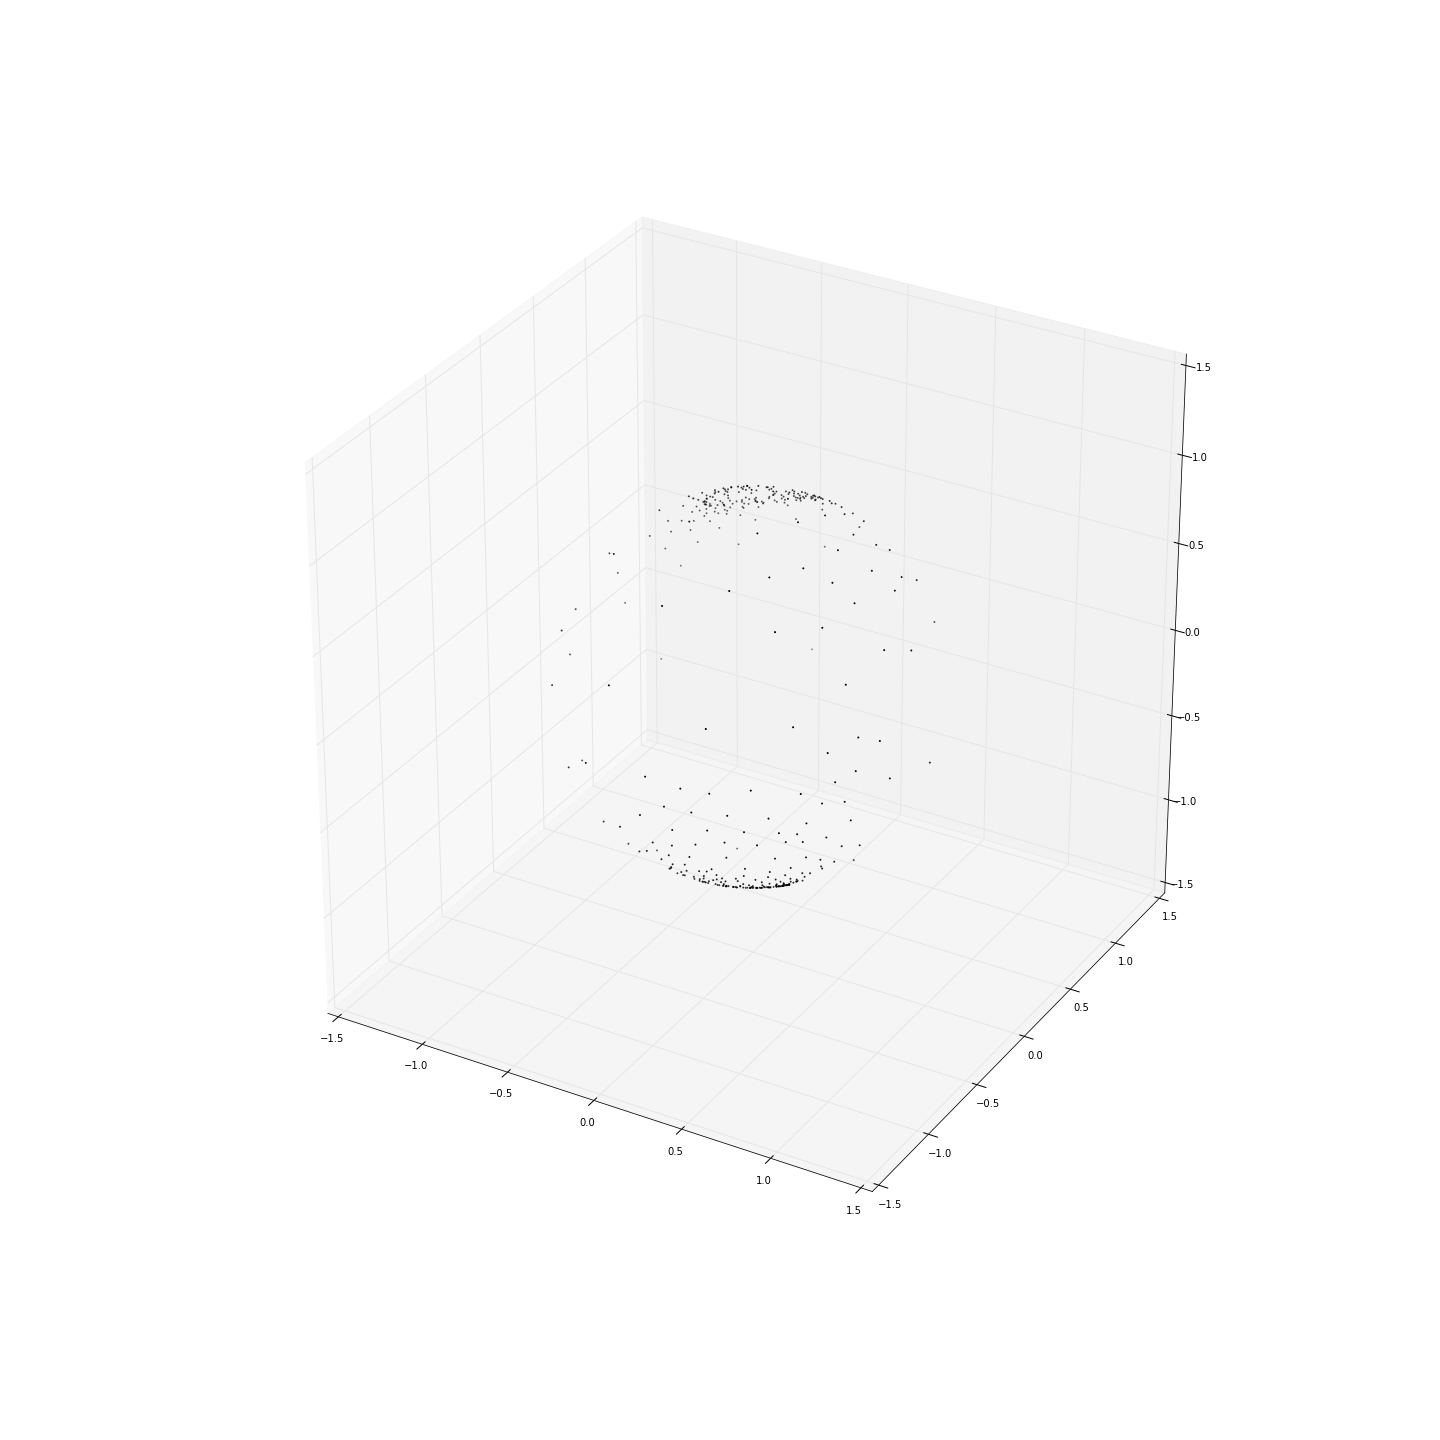

In [111]:
vs = polat_to_cartesian_3d(np.column_stack([polars[:,:2], np.ones((len(polars),))]))

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(vs[:,0], 
           vs[:,1],
           vs[:,2], c=(0,0,0), s=1)

# ax.scatter(new_reconstructed_canonical_vertices[:,0], 
#            new_reconstructed_canonical_vertices[:,1],
#            new_reconstructed_canonical_vertices[:,2], c=(0,0,0), s=1)

In [112]:
D = spharm_allInstances.reshape((6,-1))

In [113]:
from sklearn.decomposition import PCA

In [114]:
pca = PCA(n_components=3, whiten=False)
pca.fit(D)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [115]:
print(pca.explained_variance_ratio_)  

[ 0.94463794  0.03012135  0.01545356]


In [116]:
# # source: http://prideout.net/blog/?p=44
# from math import *

# def surface(slices, stacks, func):
#     verts = []
#     for i in xrange(slices + 1):
#         theta = i * pi / slices
#         for j in xrange(stacks):
#             phi = j * 2.0 * pi / stacks
#             p = func(theta, phi)
#             verts.append(p)
            
#     faces = []
#     v = 0
#     for i in xrange(slices):
#         for j in xrange(stacks):
#             next = (j + 1) % stacks
#             faces.append((v + j, v + next, v + j + stacks))
#             faces.append((v + next, v + next + stacks, v + j + stacks))
#         v = v + stacks

#     return np.array(verts), np.array(faces)

# def sphere(u, v):
#     x = sin(u) * cos(v)
#     y = cos(u)
#     z = -sin(u) * sin(v)
#     return x, y, z

# slices, stacks = 100, 100
# verts, faces = surface(slices, stacks, sphere)
# canonical_theta_phi_list = cartesian_to_polar_3d(verts)[:,:2]
# canonical_faces = np.array(faces)

In [117]:
# http://prideout.net/blog/?p=48
# icosahedron
    
def icosahedron():
    
    faces = \
    [[2, 1, 0],
        [3, 2, 0],
        [4, 3, 0],
        [5, 4, 0],
        [1, 5, 0],
        [11, 6,  7],
        [11, 7,  8],
        [11, 8,  9],
        [11, 9,  10],
        [11, 10, 6],
        [1, 2, 6],
        [2, 3, 7],
        [3, 4, 8],
        [4, 5, 9],
        [5, 1, 10],
        [2,  7, 6],
        [3,  8, 7],
        [4,  9, 8],
        [5, 10, 9],
        [1, 6, 10] ]

    verts = [
         [0.000,  0.000,  1.000],
         [0.894,  0.000,  0.447],
         [0.276,  0.851,  0.447],
        [-0.724,  0.526,  0.447],
        [-0.724, -0.526,  0.447],
         [0.276, -0.851,  0.447],
         [0.724,  0.526, -0.447],
        [-0.276,  0.851, -0.447],
        [-0.894,  0.000, -0.447],
        [-0.276, -0.851, -0.447],
         [0.724, -0.526, -0.447],
         [0.000,  0.000, -1.000]]
    return verts, faces

from euclid import *

def subdivide(verts, faces):
    """Subdivide each triangle into four triangles, pushing verts to the unit sphere
     http://prideout.net/blog/?p=44
    """
    triangles = len(faces)
    for faceIndex in xrange(triangles):
    
        # Create three new verts at the midpoints of each edge:
        face = faces[faceIndex]
        a,b,c = (Vector3(*verts[vertIndex]) for vertIndex in face)
        verts.append((a + b).normalized()[:])
        verts.append((b + c).normalized()[:])
        verts.append((a + c).normalized()[:])

        # Split the current triangle into four smaller triangles:
        i = len(verts) - 3
        j, k = i+1, i+2
        faces.append((i, j, k))
        faces.append((face[0], i, k))
        faces.append((i, face[1], j))
        faces[faceIndex] = (k, j, face[2])

    return verts, faces

canonical_verts, canonical_faces = icosahedron()

num_subdivisions = 4
for x in xrange(num_subdivisions):
    canonical_verts, canonical_faces = subdivide(canonical_verts, canonical_faces)
    
canonical_verts = np.array(canonical_verts)
canonical_faces = np.array(canonical_faces)
print len(canonical_verts), 'vertices'

canonical_theta_phi_list = cartesian_to_polar_3d(canonical_verts)[:,:2]

5112 vertices


In [118]:
# n_theta = 50
# n_phi = 50
# canonical_theta_phi_list = np.array([(theta, phi) 
#                                      for theta in np.linspace(-np.pi, np.pi, n_theta, endpoint=False) 
#                                      for phi in np.linspace(0, np.pi, n_phi, endpoint=True)])

# canonical_faces = []
# for theta_idx, theta in enumerate(np.linspace(-np.pi, np.pi, n_theta, endpoint=False)):
#     for phi_idx, phi in enumerate(np.linspace(0, np.pi, n_phi, endpoint=False)):
        
#         idx = theta_idx*n_phi+phi_idx
        
#         idx_above = None
#         idx_above_right = None
#         idx_left = None

#         if phi_idx == 0:
#             continue
# #             idx_above = theta_idx*n_theta+n_phi-1
#         elif phi_idx > 0:
#             idx_above = theta_idx*n_phi+phi_idx-1
        
#         if theta_idx == 0:
#             idx_left = (n_theta-1)*n_phi+phi_idx
#         elif theta_idx > 0:
#             idx_left = (theta_idx-1)*n_phi+phi_idx
        
#         if theta_idx == n_theta - 1:
#             idx_right_above = 0*n_phi+phi_idx-1
#         else:
#             idx_right_above = (theta_idx+1)*n_phi+phi_idx-1
           
#         if idx_left is not None and idx_above is not None:
#             canonical_faces.append((idx,idx_left,idx_above))
            
#         if idx_right_above is not None and idx_above is not None:
#             canonical_faces.append((idx,idx_above,idx_right_above))
            
# canonical_faces = np.array(canonical_faces)

# canonical_verts = polat_to_cartesian_3d(np.column_stack([canonical_theta_phi_list, np.ones((len(canonical_theta_phi_list),))]))

In [119]:
# p = mesh_to_polydata(canonical_verts, canonical_faces)
# launch_vtk([actor_mesh(p, wireframe=True, color=(0,0,0), opacity=.1)])

In [120]:
canonical_Ax = np.array([[np.real(sph_harm(m,l,theta,phi)) if m >= 0 else np.imag(sph_harm(m,l,theta,phi)) 
                for m, l in ml_list] for theta,phi in canonical_theta_phi_list])

In [121]:
c_mean = pca.mean_

In [122]:
def remove_faraway_vertices(reconstructed_canonical_vertices, canonical_faces, distance):
    new_reconstructed_canonical_vertices = []
    old_to_new_map = {}
    new_i = -1
    bad_idx = []
    for i, r in enumerate(reconstructed_canonical_vertices):
        if np.linalg.norm(r) > 1:
            bad_idx.append(i)
            continue
        new_reconstructed_canonical_vertices.append(r)
        new_i += 1
        old_to_new_map[i] = new_i
    new_reconstructed_canonical_vertices = np.array(new_reconstructed_canonical_vertices)
    
    print len(bad_idx), 'out of', len(reconstructed_canonical_vertices), 'are bad vertices'
    
    new_canonical_faces = np.array([[old_to_new_map[old_idx] for old_idx in f] for f in canonical_faces if not any([old_idx in bad_idx for old_idx in f])])
        
    return new_reconstructed_canonical_vertices, new_canonical_faces

<IPython.core.display.Javascript object>


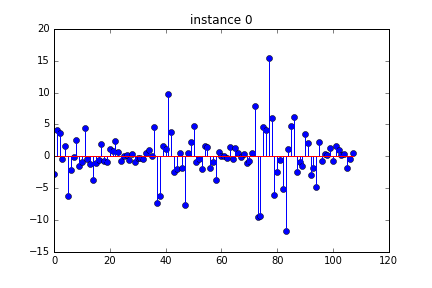

<IPython.core.display.Javascript object>


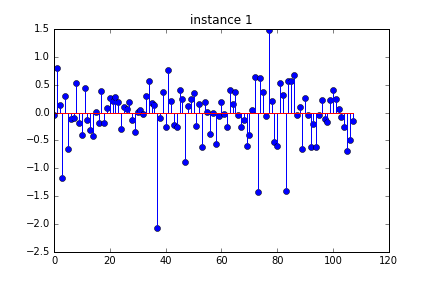

<IPython.core.display.Javascript object>


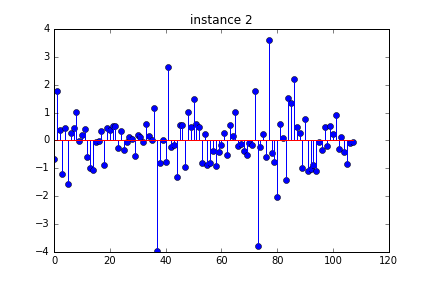

<IPython.core.display.Javascript object>


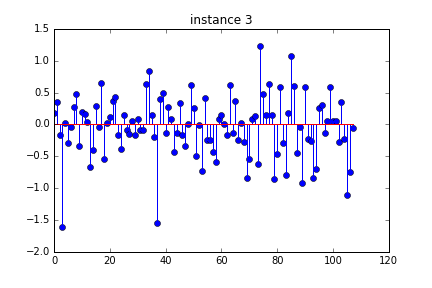

<IPython.core.display.Javascript object>


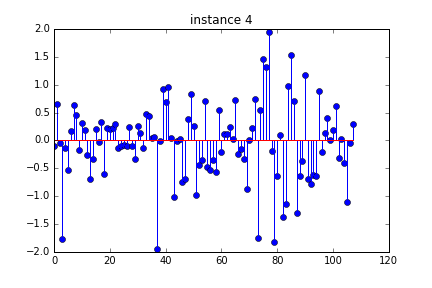

<IPython.core.display.Javascript object>


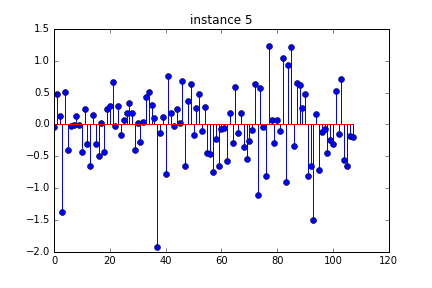

<IPython.core.display.Javascript object>


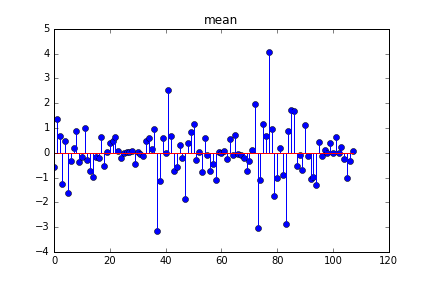

In [123]:
for i in range(6):
    plt.figure();
    plt.stem(D[i]);
    plt.title('instance %d' % i);
    
plt.figure();
plt.stem(c_mean);
plt.title('mean');

In [124]:
pc = pca.components_[0]
sv = pca.singular_values_[0]
print 'singular value', sv

reconstructed_canonical_polydatas = {}

for a in np.arange(-2, 2.5, .5):
# for a in [0]:
# for a in [1.]:

    reconstructed_canonical_vertices = np.dot(canonical_Ax, (c_mean+a*sv*pc).reshape((3,-1)).T)

#     reconstructed_canonical_polydata = vertices_to_surface(reconstructed_canonical_vertices, 
#                                                            num_simplify_iter=0, 
#                                                            smooth=False,
#                                                           neighborhood_size=5, sample_spacing=1)

    reconstructed_canonical_polydata = poisson_reconstruct_meshlab(polydata=\
                                           mesh_to_polydata(reconstructed_canonical_vertices, canonical_faces))

#     new_reconstructed_canonical_vertices, new_canonical_faces = remove_faraway_vertices(reconstructed_canonical_vertices, canonical_faces, 1)

#     reconstructed_canonical_polydata = poisson_reconstruct_meshlab(polydata=\
#                                            mesh_to_polydata(new_reconstructed_canonical_vertices, new_canonical_faces))
    
    reconstructed_canonical_polydatas[a] = reconstructed_canonical_polydata

singular value 30.9810578685
meshlabserver -i /tmp/input.ply -o /tmp/output.stl -s /home/yuncong/Brain/3d/outerContour_poisson_reconstruct.mlx -om vc vn
meshlabserver -i /tmp/input.ply -o /tmp/output.stl -s /home/yuncong/Brain/3d/outerContour_poisson_reconstruct.mlx -om vc vn
meshlabserver -i /tmp/input.ply -o /tmp/output.stl -s /home/yuncong/Brain/3d/outerContour_poisson_reconstruct.mlx -om vc vn
meshlabserver -i /tmp/input.ply -o /tmp/output.stl -s /home/yuncong/Brain/3d/outerContour_poisson_reconstruct.mlx -om vc vn
meshlabserver -i /tmp/input.ply -o /tmp/output.stl -s /home/yuncong/Brain/3d/outerContour_poisson_reconstruct.mlx -om vc vn
meshlabserver -i /tmp/input.ply -o /tmp/output.stl -s /home/yuncong/Brain/3d/outerContour_poisson_reconstruct.mlx -om vc vn
meshlabserver -i /tmp/input.ply -o /tmp/output.stl -s /home/yuncong/Brain/3d/outerContour_poisson_reconstruct.mlx -om vc vn
meshlabserver -i /tmp/input.ply -o /tmp/output.stl -s /home/yuncong/Brain/3d/outerContour_poisson_recon

In [125]:
launch_vtk([
    actor_mesh(pd, wireframe=False, color=np.array(random_colors(1))[0]/255., opacity=.3) 
    for pd in reconstructed_canonical_polydatas.itervalues()], init_angle='coronal')

In [108]:
for a, pd in sorted(reconstructed_canonical_polydatas.items()):
    print a, 'sigma'
    launch_vtk([
#         actor_sphere(color=(0,0,0)),
        actor_mesh(pd, wireframe=True, color=np.array(random_colors(1))[0]/255., opacity=1.) ],
    init_angle='coronal')

-2.0 sigma
-1.5 sigma
-1.0 sigma
-0.5 sigma
0.0 sigma
0.5 sigma
1.0 sigma
1.5 sigma
2.0 sigma


In [33]:
%matplotlib notebook

In [34]:
reconstructed_canonical_vertices = np.dot(canonical_Ax, (c_mean-0*sv*pc).reshape((3,-1)).T)

new_reconstructed_canonical_vertices = []
old_to_new_map = {}
new_i = -1
bad_idx = []
for i, r in enumerate(reconstructed_canonical_vertices):
    if np.linalg.norm(r) > 1:
        bad_idx.append(i)
        continue
    new_reconstructed_canonical_vertices.append(r)
    new_i += 1
    old_to_new_map[i] = new_i
new_reconstructed_canonical_vertices = np.array(new_reconstructed_canonical_vertices)

new_canonical_faces = np.array([[old_to_new_map[old_idx] for old_idx in f] for f in canonical_faces if not any([old_idx in bad_idx for old_idx in f])])

<IPython.core.display.Javascript object>


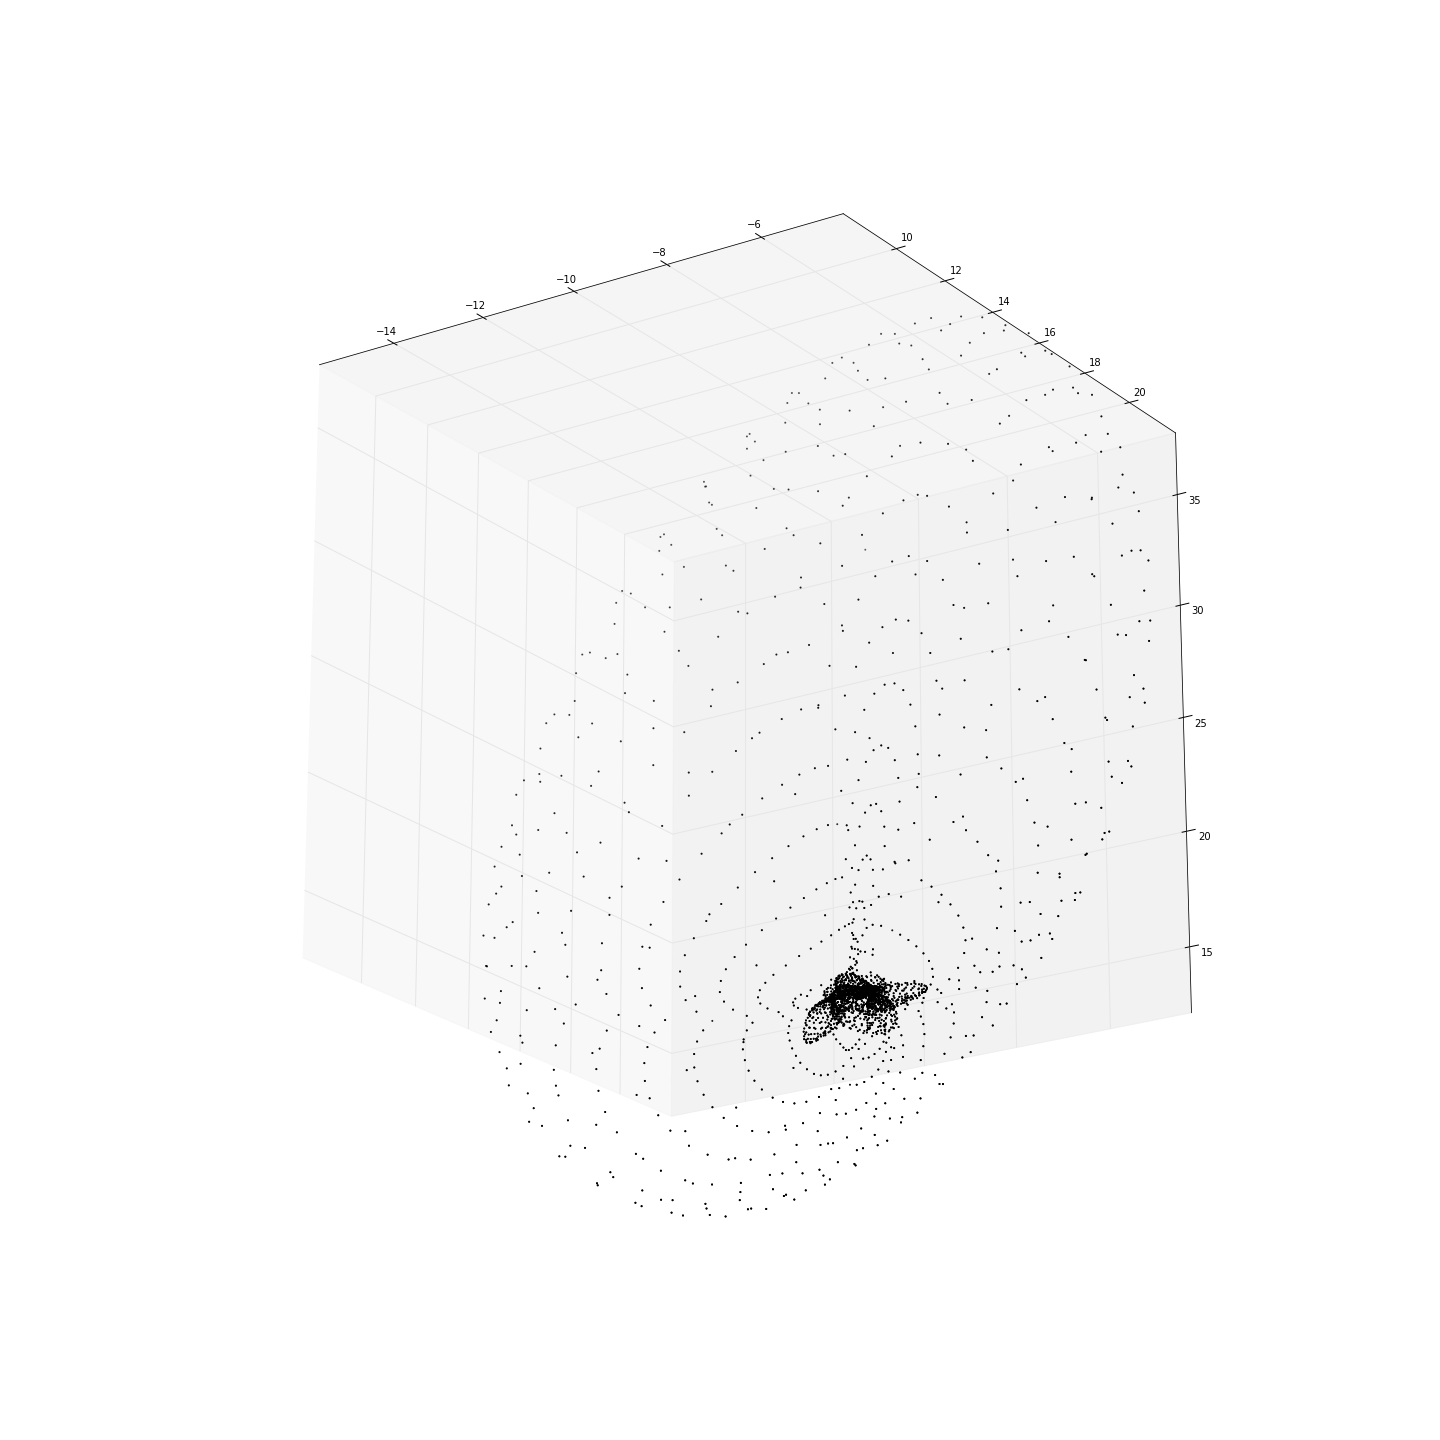

In [126]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(reconstructed_canonical_vertices[:,0], 
           reconstructed_canonical_vertices[:,1],
           reconstructed_canonical_vertices[:,2], c=(0,0,0), s=1)

# ax.scatter(new_reconstructed_canonical_vertices[:,0], 
#            new_reconstructed_canonical_vertices[:,1],
#            new_reconstructed_canonical_vertices[:,2], c=(0,0,0), s=1)